# Preprocesado de Datos

En este notebook:
1. Resolveremos los **duplicados** e inconsistencias detectadas.
2. Convertimos y depuramos columnas *object* (`categories`, `tags`…).
3. Preparamos las **métricas de engagement** ya definidas (`eng_cat`, `engagement_score`).
4. Guardamos el dataset final **`poi_dataset_prepared.csv`** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import re
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk, joblib


In [ ]:
data = pd.read_csv('../Datasets/poi_dataset_engagment.csv')


**Conversión de columnas `object`** · *Preprocesado*  
   * `categories`, `tags` → listas Python.  

In [3]:
#transformamos las columnas de categoria y tag a listas
data['categories'] = data['categories'].apply(eval)
data['tags'] = data['tags'].apply(eval)


**Fusión de duplicados** (`id` repetidos) · *Procesado*  
   * Agrupar por `id` y:   
     - Unir (`set`) `tags`.  
     - Conservar la primera fila para los campos estáticos.

In [4]:
#Vamos a fusionar las columnas id que estan duplicadas
data = data.groupby('id',as_index=False).agg({
    'name': 'first',
    'shortDescription': 'first',
    'categories': 'first',
    'tier': 'first',
    'locationLon': 'first',
    'locationLat': 'first',
    'tags': lambda x: list(set().union(*x)),
    'xps': 'first',
    'main_image_path': 'first',
    'engagement_score': 'mean'
})

In [5]:
# Recalcular etiqueta Low / Mid / High -----------------------
labels = ['Low', 'Mid', 'High']

data['eng_cat'] = pd.qcut(
    data['engagement_score'],
    q=3,
    labels=labels
).astype('category')              

print(data['eng_cat'].value_counts())

eng_cat
High    498
Low     497
Mid     497
Name: count, dtype: int64


In [6]:
print(data.shape) 

(1492, 12)


**Ingeniería de listas** · *Procesado*  
   * `categories`: Embedding de indices.  
   * `tags`: Contamos cuantos Nº de tags tiene cada poi y lo pasamos a numerico

In [7]:
#Analizamos la distribucion de las categorias
categories = data['categories'].value_counts()
categories


categories
[Patrimonio, Historia, Arquitectura]           100
[Patrimonio, Arquitectura, Historia]            84
[Historia, Cultura, Escultura]                  76
[Cultura, Escultura, Historia]                  66
[Cultura, Arquitectura, Historia]               64
                                              ... 
[Ocio, Ciencia, Arquitectura]                    1
[Ocio, Escultura, Naturaleza]                    1
[Historia, Escultura, Ciencia]                   1
[Historia, Cultura, Arquitectura, Misterio]      1
[Ocio, Cultura, Historia]                        1
Name: count, Length: 224, dtype: int64

###  Elección de **Embedding de índices** para la columna `categories`


`categories` es una lista de 12 etiquetas por POI (p. ej. `['Historia', 'Cultura']`).  
Necesitamos transformar esa información textual en algo que un modelo pueda procesar.


#### ¿Por qué embedding de índices?

1. **Dimensionalidad controlada**  
   Con 12 categorías, un embedding de 8 dimensiones reduce la entrada a  
   8 números en lugar de 12 bits sparsos.

2. **Captura relaciones semánticas**  
   El modelo puede aprender que *Historia* y *Patrimonio* estén cerca en el
   espacio vectorial, algo imposible con one-hot.



#### Implementación (fase de pre-procesado)

1. **Vocabulario** – asignamos índices `1…N` a cada categoría (0 reservado para `<pad>`).  
2. **Secuencias de índices** – cada POI se convierte en `[5, 9]`, `[1, 2]`, etc.  


In [8]:
all_cats = sorted({c for cats in data['categories'] for c in cats})
stoi     = {cat: idx + 1 for idx, cat in enumerate(all_cats)}   


data['cat_idxs'] = data['categories'].apply(
    lambda cats: [stoi[c] for c in cats]
)

# --- Comprobación rápida ---
print(data[['categories', 'cat_idxs']].head(5))

                                  categories       cat_idxs
0  [Patrimonio, Cultura, Historia, Misterio]  [11, 4, 7, 8]
1                 [Arquitectura, Patrimonio]        [1, 11]
2          [Cultura, Arquitectura, Historia]      [4, 1, 7]
3                   [Arquitectura, Historia]         [1, 7]
4        [Historia, Arquitectura, Escultura]      [7, 1, 5]


#### Secuencias *padded*
* Tras mapear las listas de categorías a índices, se genera **`cat_padded`** con longitud fija `MAX_LEN`.  
* El valor `0` rellenamos las posiciones vacías, asegurando compatibilidad directa con `nn.Embedding`

In [ ]:
cat_seqs = data['cat_idxs'].tolist()             

# ——— Padding a longitud fija ———
MAX_LEN = max(len(seq) for seq in cat_seqs)       # p. ej. 3
PAD_IDX = 0                                       # hemos reservado 0 para <pad>

cat_padded = np.zeros((len(cat_seqs), MAX_LEN), dtype='int64')  # (N, MAX_LEN)
for i, seq in enumerate(cat_seqs):
    cat_padded[i, :len(seq)] = seq               

np.save('../Others/cat_seqs.npy', cat_padded) 

                                                tags  tags_count
0  [brujas, Museos, Instalación, Inquisición, Edi...           5
1                                          [s.XVIII]           1
2  [Urbanismo, Arquitectura neoclásica, Puerta, a...          13
3                                                 []           0
4  [Urbanismo, Ciudad lineal, Transformación urba...          13


Text(0, 0.5, 'Frequency')

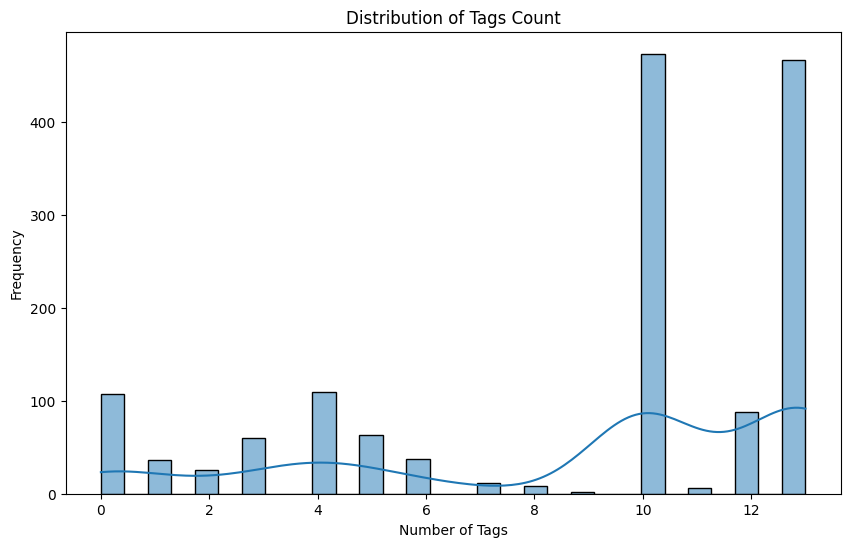

In [10]:
#Transformamos el campo tags lo contamos y añadimos un campo con el numero de tags
data['tags_count'] = data['tags'].apply(len)
# --- Comprobación rápida ---
print(data[['tags', 'tags_count']].head(5))
# --- Visualización de la distribución de tags ---
plt.figure(figsize=(10, 6)) 
sns.histplot(data['tags_count'], bins=30, kde=True)
plt.title('Distribution of Tags Count')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency') 

#### Feature de *tags*
* Se añade la columna **`tags_count`** con el número de etiquetas por POI.  
* El histograma revela una distribución **multimodal**: picos en `0` y en `10–13` tags, útil como señal para modelos tabulares.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                1492 non-null   object  
 1   name              1492 non-null   object  
 2   shortDescription  1492 non-null   object  
 3   categories        1492 non-null   object  
 4   tier              1492 non-null   int64   
 5   locationLon       1492 non-null   float64 
 6   locationLat       1492 non-null   float64 
 7   tags              1492 non-null   object  
 8   xps               1492 non-null   int64   
 9   main_image_path   1492 non-null   object  
 10  engagement_score  1492 non-null   float64 
 11  eng_cat           1492 non-null   category
 12  cat_idxs          1492 non-null   object  
 13  tags_count        1492 non-null   int64   
dtypes: category(1), float64(3), int64(3), object(7)
memory usage: 153.2+ KB


### Vectorización de **shortDescription**

**Pasos realizados**

1. **Stop-words en español**  
   Se descargan las listas de NLTK y se almacenan en `spanish_sw`.

2. **Limpieza básica** (`clean`)  
   * Minúsculas  
   * Normalización de acentos → ASCII  
   * Eliminación de caracteres no alfabéticos  
   * Colapsado de espacios

3. **TF-IDF**  
   * Vocabulario limitado a **2 000 términos** (`max_features=2000`).  
   * Stop-words españolas eliminadas.  
   * Resultado: matriz dispersa **(n × 2000)**.

4. **Reducción de dimensionalidad** – *LSA*  
   * `TruncatedSVD(n_components=100)` → matriz **(n × 100)**.  
   * Captura la semántica latente, aligera memoria y evita sobre-ajuste.

5. **Guardamos**  
   * `desc_vectors.npy` – matriz reducida.  


In [ ]:

# Lista de stop-words en español (nltk)
nltk.download('stopwords')
spanish_sw = nltk.corpus.stopwords.words('spanish')


# Función de limpieza mínima

def clean(text: str) -> str:
    text = text.lower()
    text = unicodedata.normalize("NFKD", text).encode("ascii","ignore").decode()
    text = re.sub(r"[^a-z\s]", " ", text)        # solo letras y espacios
    return re.sub(r"\s+", " ", text).strip()

desc_clean = data['shortDescription'].fillna('').map(clean)


# TF-IDF con vocabulario ≤ 2 000 términos

tfidf = TfidfVectorizer(max_features=2000, stop_words=spanish_sw)
X_tfidf = tfidf.fit_transform(desc_clean)          # sparse (n, 2000)


# Reducir a 100 componentes con SVD (LSA)


svd = TruncatedSVD(n_components=100, random_state=42)
X_desc_100 = svd.fit_transform(X_tfidf).astype("float32")  
print("Matriz de descripciones:", X_desc_100.shape)  

# Guardar en disco para usarlo después
np.save("../Others/desc_vectors.npy", X_desc_100)            



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nauzet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Matriz de descripciones: (1492, 100)


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                1492 non-null   object  
 1   name              1492 non-null   object  
 2   shortDescription  1492 non-null   object  
 3   categories        1492 non-null   object  
 4   tier              1492 non-null   int64   
 5   locationLon       1492 non-null   float64 
 6   locationLat       1492 non-null   float64 
 7   tags              1492 non-null   object  
 8   xps               1492 non-null   int64   
 9   main_image_path   1492 non-null   object  
 10  engagement_score  1492 non-null   float64 
 11  eng_cat           1492 non-null   category
 12  cat_idxs          1492 non-null   object  
 13  tags_count        1492 non-null   int64   
dtypes: category(1), float64(3), int64(3), object(7)
memory usage: 153.2+ KB


#### Limpieza final de columnas

* **Columnas eliminadas como features**  
  * `id`, `name` → identificadores / metadatos, no informativos para el modelo.  
  * `shortDescription`,  → ya vectorizadas fuera del DataFrame (TF-IDF + SVD, `desc_vectors.npy`).  
  * `engagement_score` → se sustituye por la versión categórica `eng_cat`.  
  * `cat_idx` → índice crudo; conservamos la versión *padded* en `cat_seqs.npy`.

* **Columnas que permanecen**  
  * `tier`, `xps` → numéricas/ordinales.  
  * `locationLon`, `locationLat` → coordenadas normalizables; servirán para features geoespaciales.  
  * `tags_count` → densidad semántica de etiquetas.  
  * `main_image_path` → localización de la imagen (clave para el pipeline multimodal).  
  * `eng_cat` → **target** definitivo (Low/Mid/High).

In [14]:
#Elimanos las columasn que no aportaran nada al modelo
data = data.drop(columns=['id', 'name', 'shortDescription', 'categories', 'tags','shortDescription', 'categories', 'tags','cat_idxs', 'engagement_score'])


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tier             1492 non-null   int64   
 1   locationLon      1492 non-null   float64 
 2   locationLat      1492 non-null   float64 
 3   xps              1492 non-null   int64   
 4   main_image_path  1492 non-null   object  
 5   eng_cat          1492 non-null   category
 6   tags_count       1492 non-null   int64   
dtypes: category(1), float64(2), int64(3), object(1)
memory usage: 71.7+ KB


In [ ]:
data.to_csv('../Datasets/poi_dataset_eng_pre.csv', index=False)